purpose: this is the tutorial for using ratXcan, translated over from an R markdown file, written by Sabrina Mi

# package info

In [ ]:
Data Requirements

    genotype (plink bed/bim/fam format)
    
    phenotype (TSV with columns FID, IID, phenotypes)
    
    prediction weights (*.db models on https://predictdb.org)
    
All of the data and prediction models used in the tutorial can be downloaded from Box: https://uchicago.box.com/v/ratxcan-tutorial.

Software Requirements

    plink
    
    gcta
    
    metaxcan (included in Box folder)
    
    set up conda environment

create conda environment- I used the imlabtools environment I already had

In [ ]:
#create conda environment
conda env create -f /Users/sabrinami/ratxcan-tutorial/MetaXcan/software/conda_env.yaml
conda activate imlabtools

# bash

## set-up

In [ ]:
PRE="/tscc/projects/ps-palmer/brittany/rat_genomics_paper_pipeline_2024" ## Replace with path to downloaded ratxcan-tutorial folder

OUTPUT="$PRE/output"

METAXCAN="$PRE/MetaXcan"
MODEL="$PRE/models"

GENO_PREFIX="$PRE/data/genotype/rat6k"
GENO="$PRE/data/genotype"

Both VCF and bed/bim/fam formatted genotypes are used, convert files if needed:

In [ ]:
/tscc/projects/ps-palmer/software/local/src/plink-1.90/plink --bfile $GENO_PREFIX --recode vcf --out $GENO_PREFIX
gzip -v1 ${GENO_PREFIX}.vcf

## Predict Expression


The models folder contains PrediXcan prediction models trained on 5 tissues:

nucleus accumbens (AC-filtered.db)

infralimbic cortex (IL-filtered.db)

lateral habenula (LH-filtered.db)

prelimbic cortex (PL-filtered.db)

orbitofrontal cortex (VO-filtered.db)

For the tutorial, we'll use the AC model.

In [ ]:
conda activate imlabtools
python ${METAXCAN}/software/Predict.py \
--model_db_path ${MODEL}/AC-filtered.db \
--model_db_snp_key rsid \
--vcf_genotypes ${GENO_PREFIX}.vcf.gz \
--vcf_mode genotyped \
--on_the_fly_mapping METADATA "{}_{}_{}_{}" \
--prediction_output $OUTPUT/AC-filtered-rat6k__predict.txt  \
--prediction_summary_output $OUTPUT/AC-filtered-rat6k__summary.txt \
--throw

## Compute Genetic Relatedness and Heritability

GCTA outputs a genetic relatedness matrix (GRM), then computes heritability (h2) for a given phenotype data. The following example uses bodylength data.

In [ ]:
## Compute GRM
/tscc/projects/ps-palmer/software/local/src/gcta/gcta64 --bfile $GENO/rat6k --make-grm-bin --out $OUTPUT/rat6k
## Compute h2
## argument --mpheno specifies fam column to be used as phenotype, 1 for bodylength and 2 for bmi
/tscc/projects/ps-palmer/software/local/src/gcta/gcta64 --grm $OUTPUT/rat6k --reml --pheno $PRE/data/phenotype/pheno.fam --mpheno 1 --out $OUTPUT/bodylen_h2



# R use lzenv kernel

In [7]:
#| code-fold: true
knitr::opts_chunk$set(cache=TRUE)

## compare observed correlation with null correlation plotting functions
suppressMessages(devtools::source_gist("a925fea01b365a8c605e")) ## qqR fn https://gist.github.com/hakyim/a925fea01b365a8c605e
suppressMessages(devtools::source_gist("38431b74c6c0bf90c12f")) ## qqunif https://gist.github.com/hakyim/38431b74c6c0bf90c12f
## ratxcan functions
suppressMessages(devtools::source_gist("115403f16bec0a0e871f3616d552ce9b")) ## https://gist.github.com/hakyim/115403f16bec0a0e871f3616d552ce9b 

suppressMessages(library(tidyverse))
suppressMessages(library(glue))
suppressMessages(library(readr))
suppressMessages(library(biomaRt))

## to install qvalue
## if (!require("BiocManager", quietly = TRUE))
   ## install.packages("BiocManager")
## BiocManager::install("biomaRt")

In [8]:
PRE <- "/tscc/projects/ps-palmer/brittany/rat_genomics_paper_pipeline_2024"
OUTPUT <- glue("{PRE}/output")

## Read in GRM, h2, phenotypes, and predicted gene expression

In [9]:
## read grm
grm_mat <- read_GRMBin(glue("{OUTPUT}/rat6k.grm"))
grm_id <- read_tsv(glue("{OUTPUT}/rat6k.grm.id"), col_names = FALSE)
names(grm_id) <- c("FID","IID")
## read h2
tempo <- read_tsv(glue("{OUTPUT}/bodylen_h2.hsq")) %>% filter(Source=="V(G)/Vp")
bodylen_h2 <- tempo %>% pull(Variance)
bodylen_se <- tempo %>% pull(SE)

## read phenotype
pheno_df <- read_tsv(glue("{PRE}/data/phenotype/pheno.fam"), col_names = FALSE)
names(pheno_df) <- c("FID","IID","bodylen","bmi")
## read predicted expression
pred_expr <- read_tsv(glue("{OUTPUT}/AC-filtered-rat6k__predict.txt")) %>% 
  dplyr::select(-FID) %>%  # Remove the FID column
  mutate(IID = str_split(IID, "_", simplify = TRUE)[, 1])  # Keep the first part of IID

Rows: 5628 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 10 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Source
dbl (2): Variance, SE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5401 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X1, X2
dbl (2): X3, X4

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sh

Summarize median predicted expression for all genes:

In [10]:
med_expr <- sapply(pred_expr %>% dplyr::select(-IID) %>% na.omit(), function(x) median(x, na.rm = TRUE)) %>% unname
summary(med_expr)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-4742.218    -0.442     0.000    -0.646     0.368  1998.544 

Plot distribution of median gene expression with outliers removed:

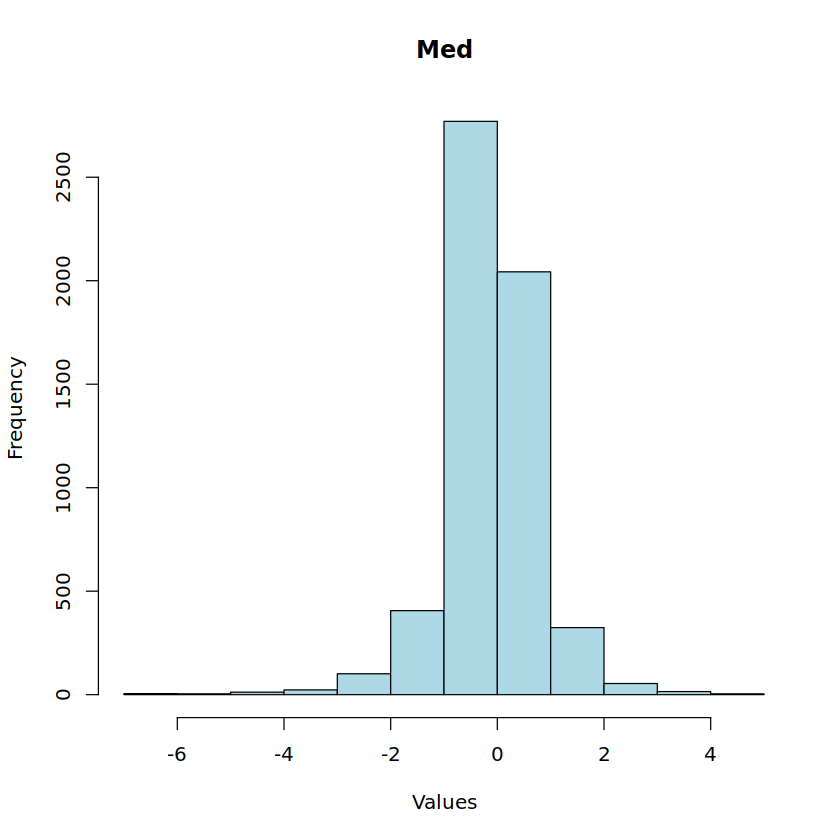

In [11]:
#| code-fold: true
lower <- quantile(med_expr, 0.01)
upper <- quantile(med_expr, 0.99)
filter_med_expr <- med_expr[med_expr >= lower & med_expr <= upper]
# breaks <- seq(min(med_expr), max(med_expr), by = 0.5)  # Adjust the 'by' value as needed
hist(filter_med_expr, main = "Med", xlab = "Values", ylab = "Frequency", col = "lightblue", border = "black")


In [ ]:
Final check that IIDs between phenotype and genotype matrices align:

In [12]:
idlist <- intersect(pheno_df$IID, grm_id$IID)
grm_mat <- grm_mat[idlist,idlist]
pheno_df <- pheno_df %>% filter(IID %in% idlist) 
if(!identical(colnames(grm_mat),pheno_df$IID))message("IIDs are not aligned between GRM and phenotype")

## Convert to Matrices

In [91]:
ymat = matrix( pheno_df$bodylen, nrow(pheno_df),1 )
rownames(ymat) = pheno_df$IID

In [92]:
exp_mat = as.matrix(pred_expr %>% dplyr::select(-IID))
rownames(exp_mat) = pred_expr$IID
exp_mat = exp_mat[rownames(ymat),]
if(!identical(rownames(exp_mat), rownames(ymat))) warning("IDs not matched")

## Run regression

In [93]:
## HERE WE USE THE FULL GRM MATRIX AND CALCULATE THE INVERSE OF THE SIGMA MATRIX}
## define lmm association function 
lmmGRM = function(pheno, grm_mat, h2, pred_expr, pheno_id_col=1,pheno_value_cols=6:6,out=NULL)
{
  ## input pheno is a data frame with id column pheno_id_col=1 by default
  ## phenotype values are in pheno_value_cols, 6:6 by default (SCORE column location in plink output), it can have more than one phenotype
  ## but h2 has to be the same, this is useful when running simulations with different h2
  ## call lmmXcan(pheno %>% select(IID,SCORE))
  
  ## format pheno to matrix form
  phenomat <- as.matrix(pheno[,pheno_value_cols])
  rownames(phenomat) <- pheno[[pheno_id_col]]
  
  ## turn pred_expr into matrix with rownames =IID, keep only IIDs in ymat
  exp_mat = as.matrix(pred_expr %>% dplyr::select(-IID))
  rownames(exp_mat) = pred_expr$IID

  ## align pheno and expr matrices
  idlist = intersect(rownames(phenomat), rownames(exp_mat))
  
  nsam = length(idlist)
  
    ## number
  num_genes <- ncol(exp_mat)

  print(glue("{nsam} samples, {num_genes} genes used in association test"))
  ## CALCULATE SIGMA
    ID_mat = diag(rep(1,nsam))
  
  Sigma = grm_mat[idlist,idlist] * h2 + (1 - h2) * ID_mat
  
  Sig_eigen = eigen(Sigma)
  rownames(Sig_eigen$vectors) = rownames(Sigma)
  
  isighalf = Sig_eigen$vectors %*% diag( 1 / sqrt(  Sig_eigen$values  ) ) %*% t(Sig_eigen$vectors)
  

  ## perform raw association
  cormat_raw = matrix_lm(phenomat[idlist,, drop = FALSE], exp_mat[idlist,])
  pmat_raw = cor2pval(cormat_raw,nsam)
  colnames(pmat_raw) <- gsub("cor_", "pval_", colnames(pmat_raw))
  
  ## perform corrected association
  cormat_correct = matrix_lm(isighalf%*% phenomat[idlist,, drop = FALSE], isighalf %*% exp_mat[idlist,])
  pmat_correct = cor2pval(cormat_correct,nsam)
  colnames(pmat_correct) <- gsub("cor_", "pval_", colnames(pmat_correct))
  
  # write outputs to file
  if(!is.null(out))
  {
    saveRDS(cormat_correct,file = glue("{out}_cormat_correct.RDS"))
    saveRDS(pmat_correct,  file = glue("{out}_pmat_correct.RDS"))
    saveRDS(cormat_raw,    file = glue("{out}_cormat_raw.RDS"))
    saveRDS(pmat_raw,      file = glue("{out}_pmat_raw.RDS"))
  }
  res = list(
    cormat_correct=cormat_correct, 
    pmat_correct=pmat_correct, 
    cormat_raw=cormat_raw, 
    pmat_raw=pmat_raw)
  return(res)
  
}

In [94]:
trait = "bodylen"
h2 = bodylen_h2
h2se = bodylen_h2+bodylen_se
##pheno, grm_mat, h2, pred_expr,pheno_id_col=1,pheno_value_cols=6:6,out=NULL

res_h2 <- lmmGRM(pheno_df,grm_mat, h2, pred_expr,pheno_id_col=1, pheno_value_cols=which(colnames(pheno_df)==trait))
# png(glue("{OUTPUT}/bodylen-AC-lmmGRM.png"))qqunif.compare(res_h2$pmat_raw,res_h2$pmat_correct,main=glue("Ratxcan bodylength") )saveRDS(res_h2,glue("{OUTPUT}/bodylen_AC_h2.RDS"))

5401 samples, 5879 genes used in association test


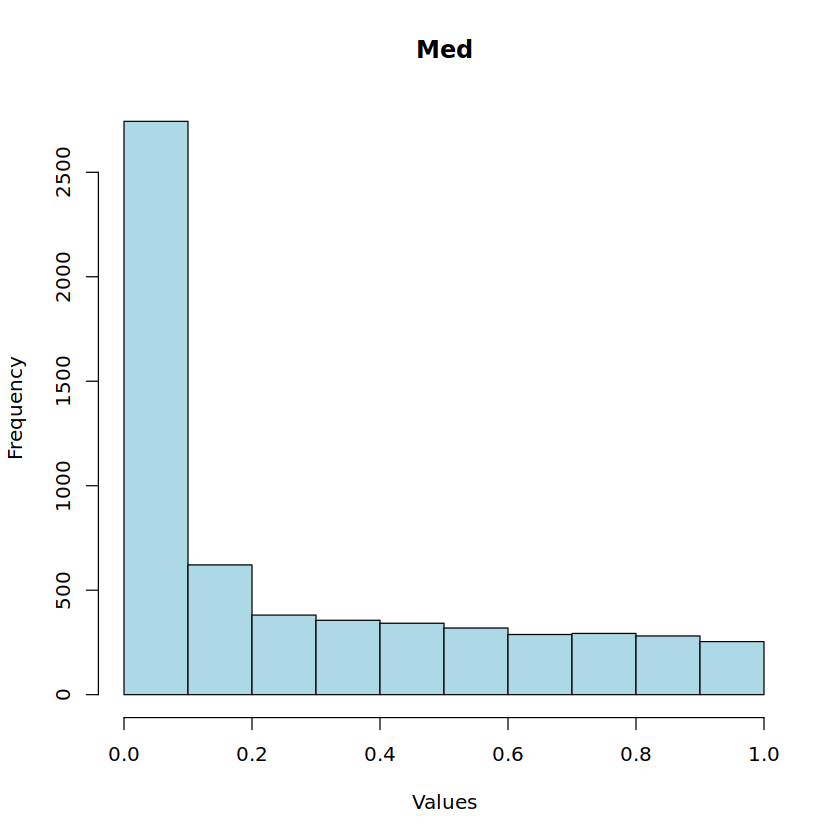

In [96]:
hist(res_h2$pmat_raw, main = "Med", xlab = "Values", ylab = "Frequency", col = "lightblue", border = "black")

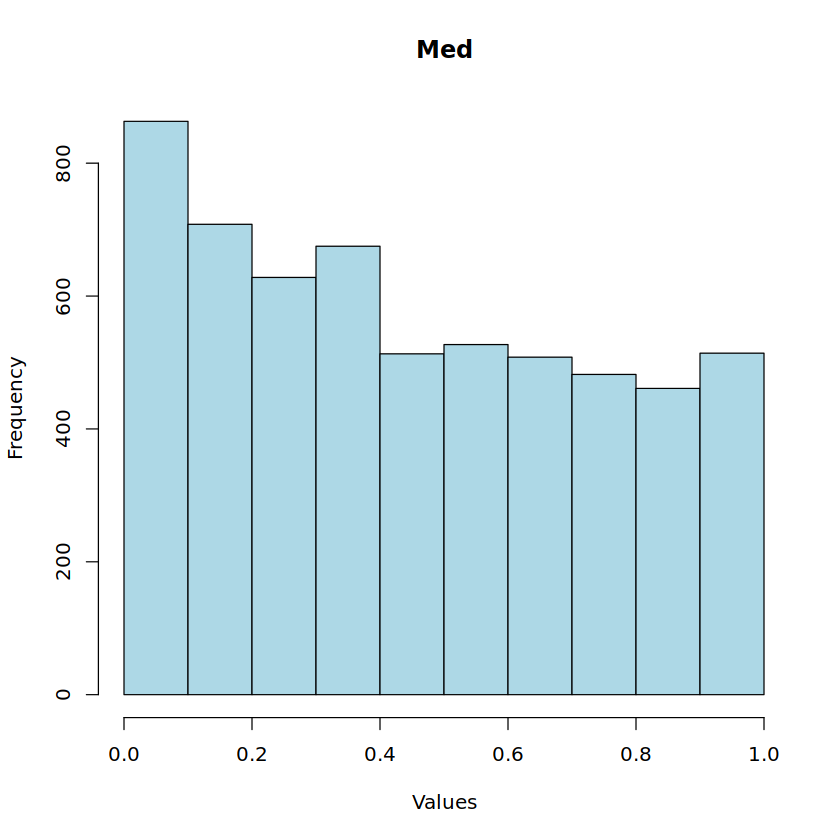

In [95]:
hist(res_h2$pmat_correct, main = "Med", xlab = "Values", ylab = "Frequency", col = "lightblue", border = "black")

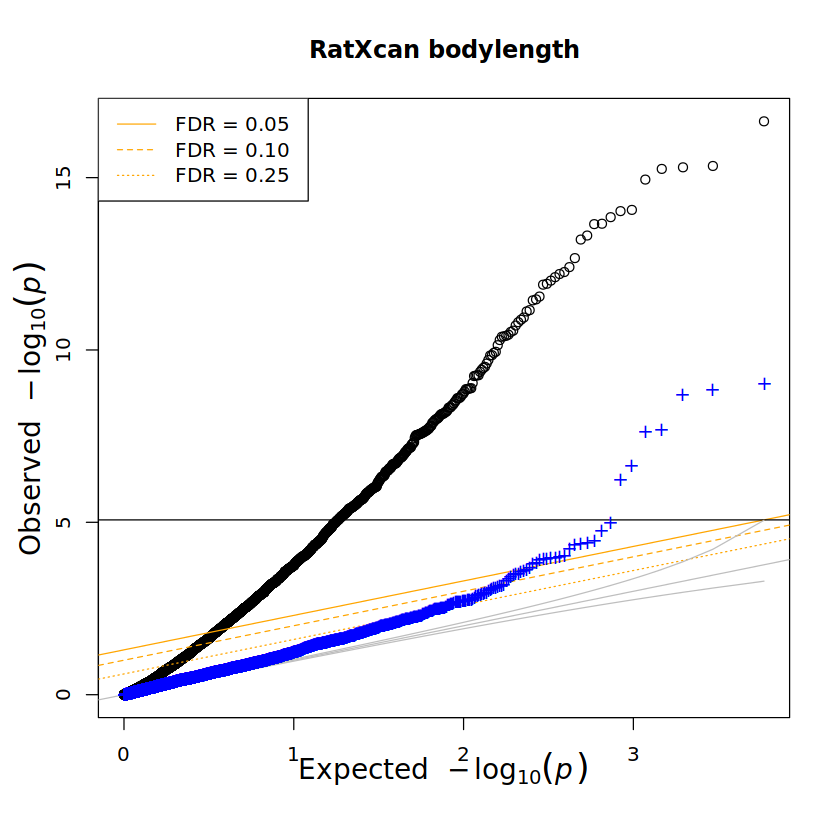

In [13]:
#png(glue("{OUTPUT}/bodylen-AC-lmmGRM.png"))
qqunif.compare(res_h2$pmat_raw,res_h2$pmat_correct,main=glue("RatXcan bodylength") )

In [16]:
## here
## qq_manhattan(tempo %>% rename(pvalue=p_acat_6))
library(ggrepel)
gg_manhattan <- function(df, titulo="",significance_threshold = 0.05) {
  ## USAGE: gg_manhattan(df,0.05)
  ## df has columns: pvalue, chr (numeric), and start (position)
  ## significance threshold gets divided by the number of tests
  ## 
  df <- df %>% filter(!is.na(pvalue))
  # Calculate cumulative base pair positions
  data_cum <- df %>%
    group_by(chr) %>%
    summarise(max_bp = as.numeric(max(start)), .groups = 'drop') %>%
    mutate(bp_add = lag(cumsum(max_bp), default = 0))

  gwas_data <- df %>%
    inner_join(data_cum, by = "chr") %>%
    mutate(bp_cum = start + bp_add)

  # Calculate axis labels
  axis_set <- gwas_data %>%
    group_by(chr) %>%
    summarize(center = mean(bp_cum), .groups = 'drop')

  # Determine the ylim based on the most significant p-value
  ylim <- gwas_data %>%
    filter(pvalue == min(pvalue)) %>%
    summarise(ylim = abs(floor(log10(pvalue))) + 2) %>%
    pull(ylim)

  # Calculate the genome-wide significance level
  sig <- significance_threshold / nrow(df)

  # Construct the Manhattan plot
  manhattan_plot <- ggplot(gwas_data, aes(x = bp_cum, y = -log10(pvalue), color = as.factor(chr), size = -log10(pvalue))) +
    geom_hline(yintercept = -log10(sig), color = "grey40", linetype = "dashed") +
    geom_hline(yintercept = -log10(0.0001), color = "red", linetype = "dashed") +
    geom_point(alpha = 0.75, shape = 19) + # Simplified shape decision for clarity
    geom_label_repel(aes(label = ifelse(pvalue <= sig, gene_name, "")), size = 3) +
    ylim(c(0, ylim)) +
    scale_x_continuous(labels = axis_set$chr, breaks = axis_set$center) +
    scale_color_manual(values = rep(c("dodgerblue4", "midnightblue"), length(unique(axis_set$chr)))) +
    scale_size_continuous(range = c(0.5, 3)) +
    labs(x = NULL, y = expression(-log[10](italic(p)))) +
    theme_minimal() +
    theme(legend.position = "none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          axis.text.x = element_text(angle = 90, size = 12),
          axis.text.y = element_text(size = 12, vjust = 0),
          axis.title = element_text(size = 20))

  if(titulo !="") manhattan_plot = manhattan_plot + ggtitle(titulo)
  return(manhattan_plot)
}

In [15]:
#| code-fold: true
human = biomaRt::useEnsembl(biomart='ensembl', dataset="hsapiens_gene_ensembl", mirror = "useast")
attributes = c("ensembl_gene_id", "external_gene_name", "rnorvegicus_homolog_ensembl_gene", "rnorvegicus_homolog_associated_gene_name")
orth.rats = biomaRt::getBM(attributes, filters="with_rnorvegicus_homolog",values=TRUE, mart = human, uniqueRows=TRUE)
# saveRDS(orth.rats,file=glue("{PRE}/data/expression/orth.rats.RDS"))


In [1]:
head(bodylen_res)

ERROR: Error in eval(expr, envir, enclos): object 'bodylen_res' not found


Rows: 10933 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): gene_name, hugo_gene, trait, gene, gene_id
dbl (12): p_acat_6, chr, start, qval, p_human, BR, AC, IL, LH, PL, VO, p_acat_5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


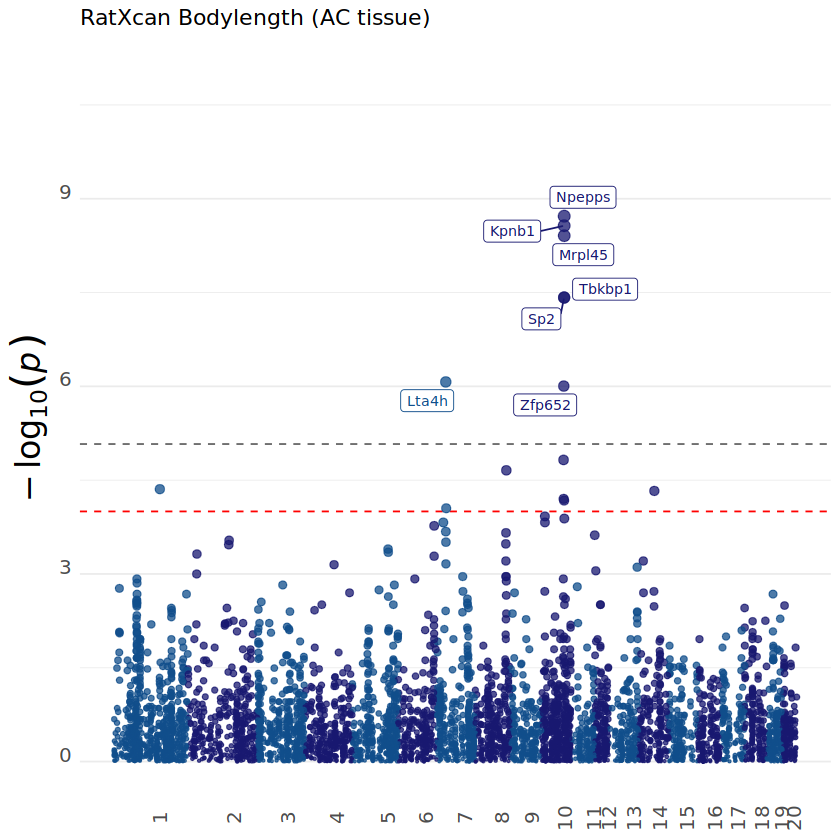

In [17]:
bodylen_res <- read_csv(glue("{PRE}/data/ratxcan-bodylen-results.csv")) %>% dplyr::select(gene_name, AC, chr, start) %>% rename(pvalue=AC)
gg <- gg_manhattan(bodylen_res, titulo="RatXcan Bodylength (AC tissue)")
# ggsave(glue("{OUTPUT}/bodylen-manhattan-p_AC.png"))
print(gg)